Testetetetet

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [2]:
# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
tf.config.optimizer.set_jit(False)  # Enable XLA for potential performance improvement

TensorFlow version: 2.4.1
GPU is available


In [3]:
# Main parameters
input_shape = (224, 224, 3)
num_classes = 38  # Number of classes in the dataset
batch_size = 8  # Increased for EfficientNetB0's lower complexity
epochs = 15

# Data directories
TRAINING_DIR = '../data/train/'
VALIDATION_DIR = '../data/val/'

In [4]:
# Data augmentation for training
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Preprocessing for validation
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Data generators
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.


In [5]:
# Load EfficientNetB0 model without the top layer (pre-trained on ImageNet)
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

# Base model layers
for layer in base_model.layers:
    layer.trainable = True

# Add classification layers on top of base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

# Create model
EfficientNet_model = Model(inputs=base_model.input, outputs=output)

# Compile model with SGD optimizer
EfficientNet_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

EfficientNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [6]:
# Train the EfficientNetB0 model:
history = EfficientNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save training history:
df = pd.DataFrame(history.history)
df.to_csv('../data/results/EfficientNetB0_15epochs.csv', index=False)

# Save the trained model weights:
EfficientNet_model.save('../models/EfficientNetB0_trained_model.h5', save_format='h5')

Epoch 1/15
4749/4749 [==============================] - 401s 80ms/step - loss: 1.3022 - accuracy: 0.6471 - val_loss: 0.3134 - val_accuracy: 0.8959
Epoch 2/15
4749/4749 [==============================] - 373s 79ms/step - loss: 0.3525 - accuracy: 0.8850 - val_loss: 0.2404 - val_accuracy: 0.9206
Epoch 3/15
4749/4749 [==============================] - 362s 76ms/step - loss: 0.2573 - accuracy: 0.9157 - val_loss: 0.1900 - val_accuracy: 0.9379
Epoch 4/15
4749/4749 [==============================] - 354s 75ms/step - loss: 0.2055 - accuracy: 0.9331 - val_loss: 0.1770 - val_accuracy: 0.9402
Epoch 5/15
4749/4749 [==============================] - 357s 75ms/step - loss: 0.1778 - accuracy: 0.9399 - val_loss: 0.1672 - val_accuracy: 0.9449
Epoch 6/15
4749/4749 [==============================] - 367s 77ms/step - loss: 0.1568 - accuracy: 0.9464 - val_loss: 0.1711 - val_accuracy: 0.9440
Epoch 7/15
4749/4749 [==============================] - 353s 74ms/step - loss: 0.1412 - accuracy: 0.9533 - val_loss: 0

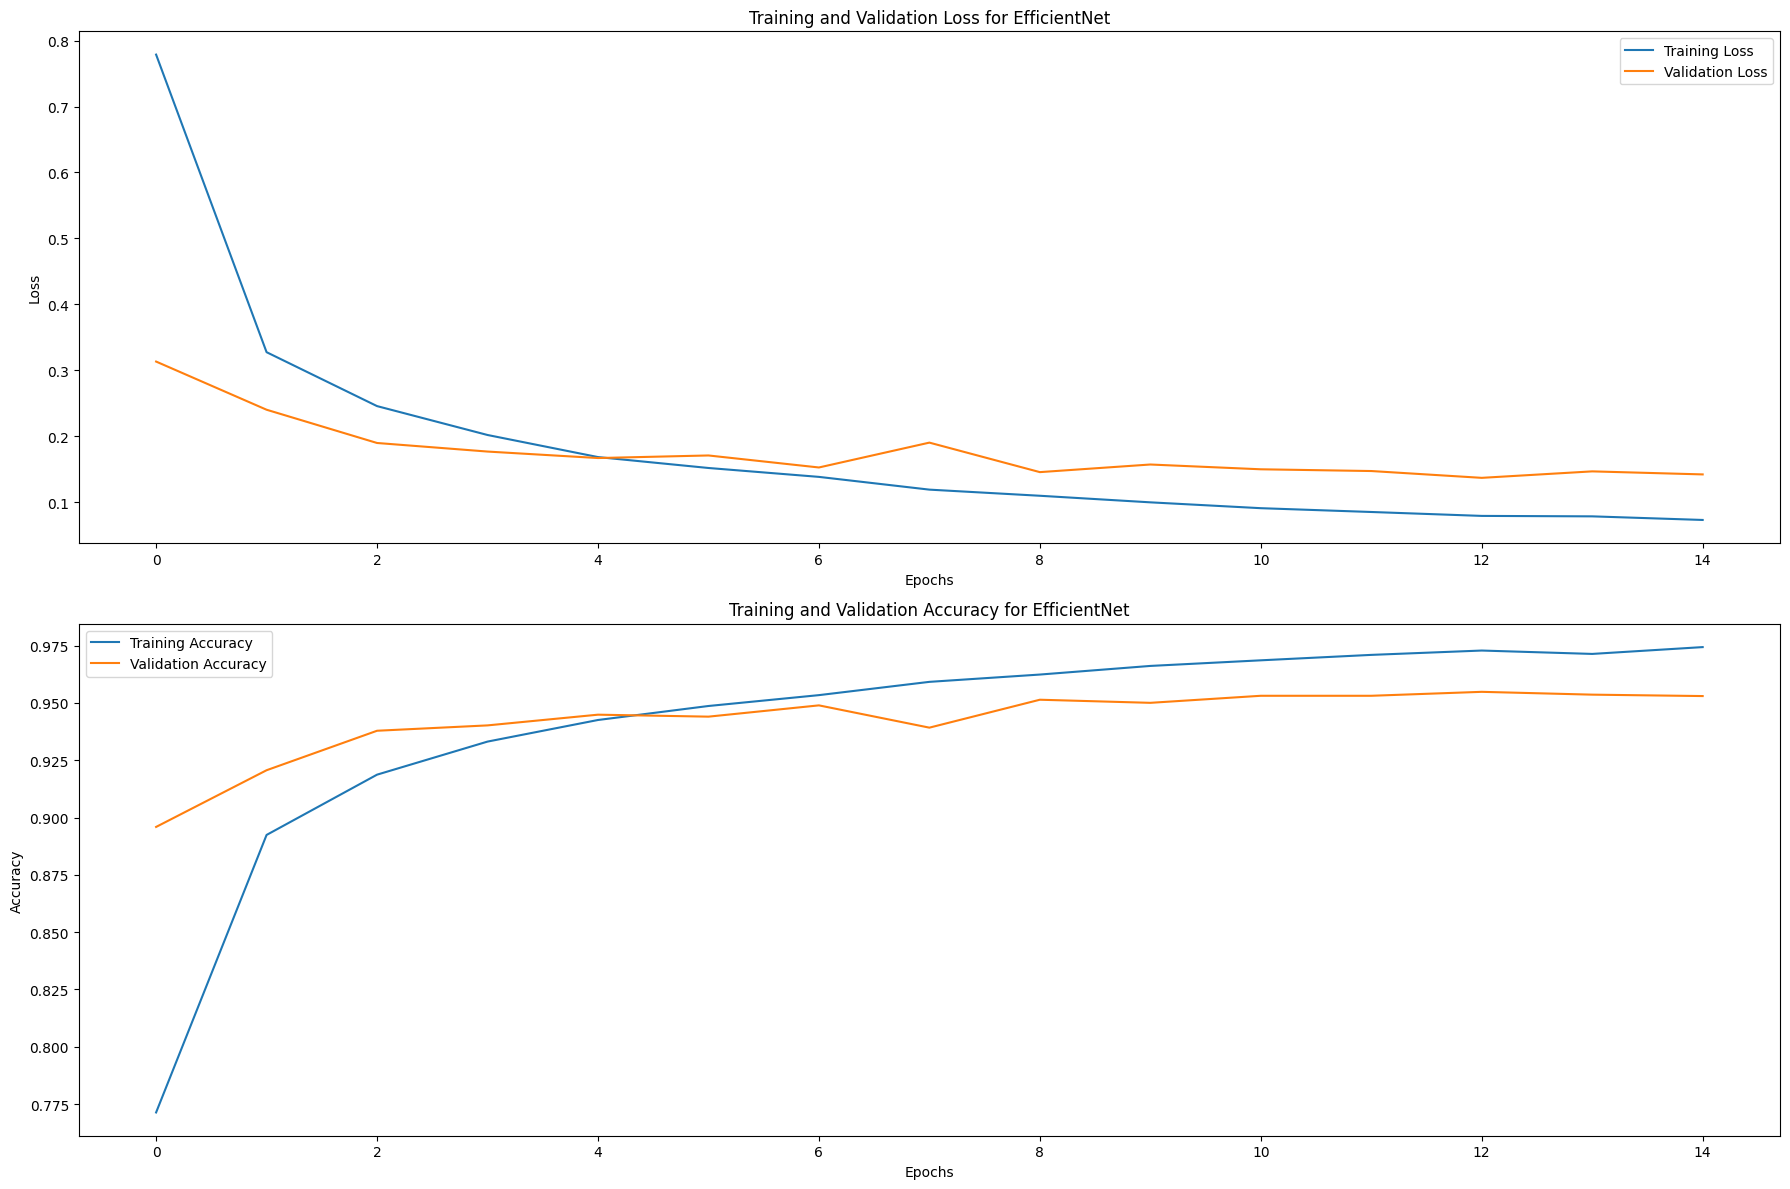

In [8]:
# Visualize training results for EfficientNet
plt.figure(figsize=(18, 12))

# 1. Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for EfficientNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2. Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for EfficientNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()